In [15]:
import pandas as pd
import re
from pathlib import Path
from typing import Optional, Tuple, List
import tf_keras as keras
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import time

In [2]:
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel
from transformers import AdamWeightDecay, TFDistilBertForSequenceClassification
import tensorflow as tf
from typing import List, Tuple
import safetensors
print(f"Transformers: {transformers.__version__}")
print(f"Safetensors: {safetensors.__version__}")

/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Transformers: 4.38.0
Safetensors: 0.4.2


In [ ]:
def create_text_chunks(text: str, tokenizer: DistilBertTokenizer, 
    chunk_size: int = 512, 
    overlap: int = 50) -> List[str]:
    """
    Splits a long text into smaller, overlapping chunks based on tokens.

    Args:
        text (str): The long text document to be chunked.
        tokenizer (DistilBertTokenizer): The tokenizer to use for splitting the text.
        chunk_size (int): The target size of each chunk in tokens.
        overlap (int): The number of tokens to overlap between chunks.

    Returns:
        List[str]: A list of text strings, where each string is a chunk.
    """
    # Tokenizes the entire text to get a list of token IDs
    tokens = tokenizer.encode(text, add_special_tokens=False)
    
    # If the text is short enough, no chunking is needed
    if len(tokens) <= chunk_size:
        return [text]

    # Calculates the step size for sliding the window
    step_size = chunk_size - overlap
    
    chunks = []
    # Slides a window over the list of tokens
    for i in range(0, len(tokens) - overlap, step_size):
        chunk_tokens = tokens[i:i + chunk_size]
        # Converts the token chunk back into a string for the tokenizer to process later
        chunk_text = tokenizer.decode(chunk_tokens)
        chunks.append(chunk_text)
        
    return chunks

In [ ]:
def create_chunk_dataset(
    df: pd.DataFrame, 
    tokenizer: DistilBertTokenizer
) -> pd.DataFrame:
    """
    Creates a new DataFrame where each row is a text chunk, associated with
    the original document's label.

    Args:
        df (pd.DataFrame): DataFrame with 'text' and 'PHQ8_Binary' columns.
        tokenizer (DistilBertTokenizer): The tokenizer for chunking.

    Returns:
        pd.DataFrame: A new DataFrame with 'chunk_text' and 'label' columns.
    """
    new_rows = []
    # Iterates through each original document (each row in the input df)
    for index, row in df.iterrows():
        original_text = row['text']
        original_label = row['PHQ8_Binary']
        
        # Creates chunks from the original text
        text_chunks = create_text_chunks(original_text, tokenizer)
        
        # For each chunk, creates a new row with the chunk text and the original label
        for chunk in text_chunks:
            new_rows.append({'chunk_text': chunk, 'label': original_label})
            
    return pd.DataFrame(new_rows)

In [35]:
def tokenize_and_create_tf_dataset(
    df: pd.DataFrame, 
    tokenizer: DistilBertTokenizer, 
    max_length: int = 512, 
    batch_size: int = 16
):
    """
    Tokenizes a DataFrame of text chunks and converts it into a TensorFlow Dataset.

    Args:
        df (pd.DataFrame): DataFrame with 'chunk_text' and 'label' columns.
        tokenizer (DistilBertTokenizer): The tokenizer to use.
        max_length (int): The maximum token length for padding/truncation.
        batch_size (int): The batch size for the TensorFlow dataset.

    Returns:
        tf.data.Dataset: A batched dataset ready for model training.
    """
    # Tokenizes all the text chunks at once
    tokenized_output = tokenizer(
        df['chunk_text'].tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )
    
    labels = df['PHQ_Binary'].values
    
    # Creates the TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(tokenized_output), labels)
    )
    
    # Shuffles and batch the dataset
    dataset = dataset.shuffle(len(df)).batch(batch_size)
    
    return dataset

In [ ]:
def build_distilbert_classifier():
    model = TFDistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=1
    )

    optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [7]:
def clean_text(text: str) -> str:
    """
    Performs gentle text cleaning for NLP models.
    - Converts text to lowercase.
    - Removes special characters, replacing them with a space.
    - Removes extra whitespace.

    Args:
        text (str): The input text string.

    Returns:
        str: The cleaned text string.
    """
    text = str(text).lower()  # Convert to lowercase
    # Replace any character that is not a letter, number, or whitespace with a space
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Replace multiple whitespace characters with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [8]:
def load_and_clean_dataset(data_path: Path) -> Optional[pd.DataFrame]:
    """
    Loads a dataset from a CSV file and applies basic text cleaning.

    Args:
        data_path (Path): The full path to the input CSV file.

    Returns:
        Optional[pd.DataFrame]: The loaded and cleaned DataFrame, or None if an error occurs.
    """
    if not data_path.is_file():
        print(f"Error: The file was not found at the specified path: {data_path}")
        return None

    try:
        df = pd.read_csv(data_path)
        print(f"Successfully loaded {len(df)} records from {data_path.name}.")
        
        # --- Apply the cleaning function ---
        print("Applying text cleaning...")
        df['cleaned_text'] = df['text'].apply(clean_text)
        print("Text cleaning complete.")
        
        return df
        
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [9]:
import sys
print(f"Python: {sys.version}")

try:
    import tensorflow as tf
    print(f"TensorFlow: {tf.__version__}")
except ImportError as e:
    print(f"TensorFlow import error: {e}")

try:
    import keras
    print(f"Keras: {keras.__version__}")
except ImportError as e:
    print(f"Keras import error: {e}")

Python: 3.11.6 (v3.11.6:8b6ee5ba3b, Oct  2 2023, 11:18:21) [Clang 13.0.0 (clang-1300.0.29.30)]
TensorFlow: 2.20.0
Keras: 3.11.3


In [10]:
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy.

    Args:
        history: The History object returned by the model.fit() method.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    ax1.grid(True)

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    ax2.grid(True)

    plt.show()

Successfully loaded 107 records from final_training_dataset.csv.
Applying text cleaning...
Text cleaning complete.
Successfully loaded 35 records from final_dev_dataset.csv.
Applying text cleaning...
Text cleaning complete.
--- 1. Starting with 5 sample documents ---
     participant_id                                               text  \
0               303  okay how 'bout yourself here in california yea...   
1               304  i'm doing good um from los angeles california ...   
2               305  i'm doing alright uh originally i'm from calif...   
3               310  yes it's okay <laughter> fine <laughter> i liv...   
4               312  yes fine how about you here yes the weather we...   
..              ...                                                ...   
102             485  <synch> yes i'm not bad i'm a little tired but...   
103             486  <synch> yes i'm feel great i am from saint lou...   
104             487  <synch> yes i'm fine thank you detroit michig

/Users/ujjwalpoudel/Documents/insane_projects/Conversational-Health-Analytics-/.newvenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (2224 > 512). Running this sequence through the model will result in indexing errors



Created 410 training chunks and 148 validation chunks.

--- 3. Tokenizing and creating TensorFlow dataset ---
TensorFlow datasets created successfully.

--- 4. Building the model ---


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66954241 (255.41 MB)
Trainable params: 66954241 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

--- 5. Starting model training on the FULL da

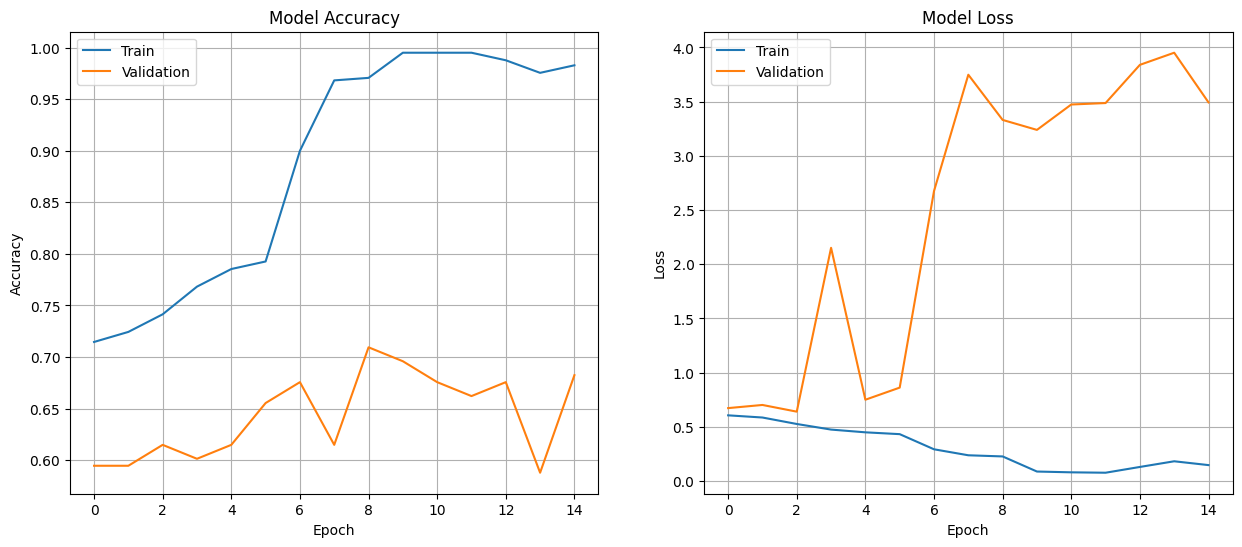

In [11]:
if __name__ == '__main__':
    training_data_path = Path('/Volumes/MACBACKUP/final_training_dataset.csv')
    validation_data_path = Path('/Volumes/MACBACKUP/final_dev_dataset.csv')
    
    full_train_df = load_and_clean_dataset(training_data_path)
    sample_df = full_train_df
    
    full_dev_df = load_and_clean_dataset(validation_data_path)

    print("Starting with 5 sample documents")
    print(full_train_df)

    # Preprocessing
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    print("\nCreating chunk-based dataset")
    chunk_df = create_chunk_dataset(sample_df, tokenizer)
    dev_chunk_df = create_chunk_dataset(full_dev_df, tokenizer)
    
    print(f"Created {len(chunk_df)} training chunks and {len(dev_chunk_df)} validation chunks.")

    print("\nTokenizing and creating TensorFlow dataset ")
    train_dataset = tokenize_and_create_tf_dataset(chunk_df, tokenizer)
    dev_dataset = tokenize_and_create_tf_dataset(dev_chunk_df, tokenizer)
    print("TensorFlow datasets created successfully.")

    # --- Model Training ---
    print("\nBuilding the model ---")
    model = build_distilbert_classifier()
    model.summary()
    
    start_time = time.time()
    
    # # Define Callbacks
    # # EarlyStopping will stop training when the validation loss hasn't improved for a few epochs.
    # early_stopping = EarlyStopping(
    #     monitor='val_loss',      # Monitor the validation loss
    #     patience=3,              # Stop after 3 epochs of no improvement
    #     restore_best_weights=True # Restore model weights from the epoch with the best val_loss
    # )

    # # ModelCheckpoint will save the best version of your model to a file.
    # model_checkpoint = ModelCheckpoint(
    #     'models/best_distilbert_model.h5', # Filepath to save the model
    #     save_best_only=True,        # Only save when the model is considered the "best"
    #     monitor='val_loss',         # The metric to monitor
    #     mode='min'                  # We want to minimize the validation loss
    # )
    
    # print_callback = LambdaCallback(
    # on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1}: loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f}"))
    
    print("\nStarting model training on the FULL dataset")
    
    start_time = time.time()

    print("\nStarting model training (on the 5-document sample)")
    # For a real run, you would also pass a validation_data argument
    history = model.fit(
        train_dataset,
        epochs=15, # Set a higher number of epochs; EarlyStopping will find the best one
        validation_data=dev_dataset, # Provide the validation dataset
    )
    
    end_time = time.time()
    duration_minutes = (end_time - start_time) / 60
    
    print("\n--- Training Complete ---")
    print(f"Total training time: {duration_minutes:.2f} minutes")
    
    # --- 6. Plotting Results ---
    print("\n--- Generating Training History Plot ---")
    plot_training_history(history)

In [ ]:
# Model Training 2
print("\nBuilding the model ---")
model2 = build_distilbert_classifier()
model2.summary()
    
start_time2 = time.time()

In [ ]:
print("\nStarting model2 training on the FULL dataset")
    
start_time = time.time()

print("\nStarting model training")
history2 = model2.fit(
    train_dataset,
    epochs=6,
    validation_data=dev_dataset, # Providing the validation dataset
)
    
end_time2 = time.time()
duration_minutes = (end_time2 - start_time2) / 60
    
print("\nTraining Complete")
print(f"Total training time: {duration_minutes:.2f} minutes")
    
# Plotting Results
print("\nGenerating Training History Plot")
plot_training_history(history2)

In [25]:
def create_chunk_dataset_with_ids(df: pd.DataFrame, tokenizer: DistilBertTokenizer) -> pd.DataFrame:
    """
    Creates a new DataFrame of chunks, keeping the original participant_id for each chunk.
    This function depends on your existing 'create_text_chunks' function.
    """
    new_rows = []
    for index, row in df.iterrows():
        participant_id = row['participant_id']    # Keep the original ID
        original_text = row['cleaned_text']       # Use the cleaned text
        
        # Creates chunks from the original text using your helper function
        text_chunks = create_text_chunks(original_text, tokenizer)
        
        # For each chunk, creates a new row with the chunk text and the original ID
        for chunk in text_chunks:
            new_rows.append({'participant_id': participant_id, 'chunk_text': chunk})
            
    return pd.DataFrame(new_rows)

In [36]:
test_data_path = Path('/Volumes/MACBACKUP/final_test_dataset.csv') 
full_test_df = load_and_clean_dataset(test_data_path)

# Creates the chunks using your tokenizer
test_chunk_df = create_chunk_dataset_with_ids(full_test_df, tokenizer)

# Creates the final dataset, also using the same tokenizer
test_dataset = tokenize_and_create_tf_dataset(test_chunk_df, tokenizer)

Successfully loaded 47 records from final_test_dataset.csv.
Applying text cleaning...
Text cleaning complete.


KeyError: 'PHQ_Binary'

In [ ]:
# Select Which In-Memory Model to Use
final_model = model

# Generates Predictions
print("\\nGenerating predictions for test chunks")

# This feeds the test_dataset into the selected model
chunk_predictions = final_model.predict(test_dataset)

# The output is a NumPy array of probabilities. Let's see the first 5.
print("Predictions generated successfully.")
print("First 5 chunk predictions (raw probabilities):")
print(chunk_predictions[:5])

In [ ]:
# Adding the chunk predictions to the DataFrame
# This aligns each prediction with its corresponding chunk and participant_id
test_chunk_df['predicted_prob'] = chunk_predictions


# Grdoups by participant and aggregate
print("\\nAggregating chunk predictions to document level")
# Groups by the original document ID and calculate the mean probability for each document
agg_preds = test_chunk_df.groupby('participant_id')['predicted_prob'].mean().reset_index()

# Determines the final binary prediction (0 or 1) based on a 0.5 threshold
agg_preds['final_prediction'] = (agg_preds['predicted_prob'] >= 0.5).astype(int)

print("Aggregation complete.")
print("Aggregated Predictions Head:")
print(agg_preds.head())

In [ ]:
# Displaying Results in a Readable Format
print("\\nFinal Document-Level Predictions")
# Merges the aggregated predictions back with the original test data for context
final_results = pd.merge(full_test_df, agg_preds, on='participant_id')

# Selects and displays the most important columns
final_display = final_results[['participant_id', 'predicted_prob', 'final_prediction', 'text']]

# Renaming columns for clarity
final_display = final_display.rename(columns={
    "predicted_prob": "Aggregated_Depression_Probability",
    "final_prediction": "Final_PHQ8_Binary_Prediction"
})

print(final_display)

In [ ]:
if 'PHQ8_Binary' in final_results.columns:
    y_true = final_results['PHQ8_Binary']
    y_pred = final_results['Final_PHQ8_Binary_Prediction']
    print("True labels (y_true) and predicted labels (y_pred) are ready for evaluation.")
else:
    print("Error: The true label column 'PHQ8_Binary' was not found in the final_results DataFrame.")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# Ensures both y_true and y_pred are available before proceeding
if 'y_true' in locals() and 'y_pred' in locals():

    # Individual Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("Individual Performance Metrics")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Detailed Classification Report
    print("\\nClassification Report")
    # This report provides a breakdown of precision, recall, and f1-score for each class (0 and 1)
    print(classification_report(y_true, y_pred, target_names=['Not Depressed (0)', 'Depressed (1)']))

    # Confusion Matrix
    print("\\n--- Confusion Matrix ---")
    # This shows the breakdown of correct and incorrect predictions
    # [[True Negative, False Positive],
    #  [False Negative, True Positive]]
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

GPU is NOT available. TensorFlow is running on the CPU.


In [29]:
import pandas as pd
import re
from pathlib import Path

def preprocess_transcript_csv(input_path: Path, output_path: Path, bot_name: str = 'Ellie'):
    """
    Reads a raw transcript CSV, removes bot dialogue and timestamps, 
    and saves a cleaned version.

    Args:
        input_path (Path): Path to the raw input CSV file.
        output_path (Path): Path to save the clean output CSV file.
        bot_name (str): The name of the bot speaker to remove (e.g., 'Ellie').
    """
    try:
        df = pd.read_csv(input_path)
    except FileNotFoundError:
        print(f"Error: Input file not found at {input_path}")
        return

    cleaned_transcripts = []
    
    # Process each participant's full transcript
    for transcript in df['value']:
        participant_lines = []
        # Split the transcript into individual lines
        for line in str(transcript).split('\\n'):
            # Ignore lines spoken by the bot
            if line.strip().lower().startswith(bot_name.lower() + ':'):
                continue
            
            # Remove timestamps like [00:00:00]
            cleaned_line = re.sub(r'\\[\\d{2}:\\d{2}:\\d{2}\\]', '', line).strip()
            
            # Also remove the "Participant:" tag if it exists
            if cleaned_line.lower().startswith('participant:'):
                cleaned_line = cleaned_line[12:].strip()

            if cleaned_line:
                participant_lines.append(cleaned_line)
        
        # Join the participant's lines back into a single block of text
        cleaned_transcripts.append(' '.join(participant_lines))

    # Create a new DataFrame with the clean text
    new_df = df[['participant_id', 'PHQ8_Binary']].copy()
    new_df['text'] = cleaned_transcripts
    
    # Save the clean data to the new CSV file
    new_df.to_csv(output_path, index=False)

In [31]:
raw_test_data_path = Path('/Volumes/MACBACKUP/full_test_split.csv')

# Define where you want to save the new, clean file
clean_test_data_path = Path('/Volumes/MACBACKUP/final_test_dataset.csv')

# Run the preprocessing function
# If your bot has a different name, change it here
preprocess_transcript_csv(raw_test_data_path, clean_test_data_path, bot_name='Ellie')

print(f"Preprocessing complete. Clean file saved to: {clean_test_data_path}")

KeyError: 'value'